# Use Fifferent Transforms and Analyze Their Use for a Machine Learning Inversion

_notebook created by:_ Max Schmitz (mschmitz7@gatech.edu)
_on:_ 03/03/2023

The goal of this notebook is to apply different transformations besides the used 2D-FFT to the simulated data and analyze the use of the different transformations for a thickness inversion.

This notebook will
1. load a 2D-FFT file with respective frequency and wave number grid and apply the inverse 2D-FFT to obtain the data in the _time $\times$ displacement_ domain. (This way is deprecated - start with step 2 directly)
2. load the simulation-wise obtained displacement x time array from a .csv file and start working on that
3. transform the data with noise from the time-displacement domain. For this, various transformations are used:
        - Short-time fourier transformation (STFT)
        - Wavelet transformation (WT)
        - Wigner–Ville distribution (WVD)
4. apply non-maximum suppression or so to obtain features for machine learning
5. use extracte features in machine learning classifiers for classification or even regression

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np

from utils import (
      load_2dfft_processed_data,
      invert_2dfft,
      add_noise,
      store_fft_data,
      non_maximum_suppression,
      extract_features,
      lin_func,
      load_input_data
)

In [ ]:
# # comment out the following or do not run this cell if you do not want to export to latex
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [5]:
def check_and_create_path(path: pathlib.Path = None) -> None:
    """ checks if folder at path exists already and creates
        new folder at path if not

        :arg: path - pathlib.Path() - path that should be checked/created
    """
    exists = os.path.exists(path)
    if not exists:
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"The new directory at \n>>> {path} <<<\nis created!")
    else:
        print(f"Directory at \n>>> {path} <<<\nis already existing!")

In [12]:
save_figures = True
figure_path = pathlib.Path().resolve() / '2dfft_data_selected' / 'figures_transforms'
check_and_create_path(figure_path)

Directory at 
>>> C:\Users\Max\OneDrive\Documents\Uni Gatech MSC\A Lab Research Wave CEE\A Journal Paper\ml_dl_wave_inversion\create_model\2dfft_data_selected\figures_transforms <<<
is already existing!


In [186]:
# -- Specify folder to work in/where data lays
# 100._1._1._1._0
# 200._1._1._1._0
# 300._1._1._1._0
# 400._1._1._1._0
# 500._1._1._1._0
# 600._1._1._1._0

data_path = pathlib.Path().resolve() / '2dfft_data_selected' / '600._1._1._1._0'    # put data here
check_and_create_path(data_path)

Directory at 
>>> C:\Users\Max\OneDrive\Documents\Uni Gatech MSC\A Lab Research Wave CEE\A Journal Paper\ml_dl_wave_inversion\create_model\2dfft_data_selected\600._1._1._1._0 <<<
is already existing!


## _1.1. load a 2D-FFT file_

_!!! discard this and the next step and directly load the displacement data from 2.1!!!_

Since I removed the phase information, officially "3/4" of the information is lost - this means when I transform the data back into the time-frequency domain, I get only 1/4 of the measurement points. Initially, I had 0.04m=4cm of sampling with a spatial/ sampling distance of 5.821107385130693e-06m. This means, there are approx. 6800 sampling locations.

In [3]:
# -- Specify file names for example file
fn = '10-14_16-24-27_max_analysis_job_disp_2dfft_fg_0.0002.csv'

fg, kg, abs_fft_data, sim_info = load_2dfft_processed_data(fn, data_path)
print('>> frequency-/wavenumber grid, 2D-FFT data, and simulation information file was loaded!')

print(f'fg.shape = {fg.shape}\n'
      f'kg.shape = {kg.shape}\n'
      f'abs_fft_data.shape = {abs_fft_data.shape}\n')

>> frequency-/wavenumber grid, 2D-FFT data, and simulation information file was loaded!
fg.shape = (2300, 1718)
kg.shape = (2300, 1718)
abs_fft_data.shape = (2300, 1718)



## _1.2. apply the inverse 2D-FFT_

_!!! discard this and the previous step and directly load the displacement data from 2.1!!!_

In [4]:
displacement_x_time, dt, dx, Nt, Nx = invert_2dfft(fg, kg, abs_fft_data, sim_info)
print('>> 2D-FFT data has been inverted to displacement-time data!')

print(f'displacement_x_time.shape = {displacement_x_time.shape}')

>> 2D-FFT data has been inverted to displacement-time data!
displacement_x_time.shape = (2300, 1718)


## 2.1 Load Displacement Data

Take the true displacement data from the simulation directly without back and forth transforming the data. The first dimension of the array is the sampling time, the second dimension is the displacement.

In [187]:
input_data, data_file, sim_info = load_input_data(data_path, j_name='max_analysis_job')      # 'max_analysis_job_upgraded' only for 200 microns coating
assert input_data.shape == (4601, 6875), "Dimensions do not match! Make sure displacement data and not 2D-FFT data is loaded."

In [188]:
coating_height = sim_info['c_height'] * 1E6     # get coating height in microns
print(f"The coating height to be analyzed is {coating_height} microns.")

The coating height to be analyzed is 600.0 microns.


Select the first sampling node in the following. Generally, every sampling node could be used. Analyzing if a node further from the excitation might be a better choice needs to be checked later.

In [195]:
displacement_x_time = input_data
node_number = 1
displacement_timeseries = displacement_x_time[:,node_number]
print(displacement_timeseries.shape)

(4601,)


#### Analyze the data from the simulation in the time-displacement domain

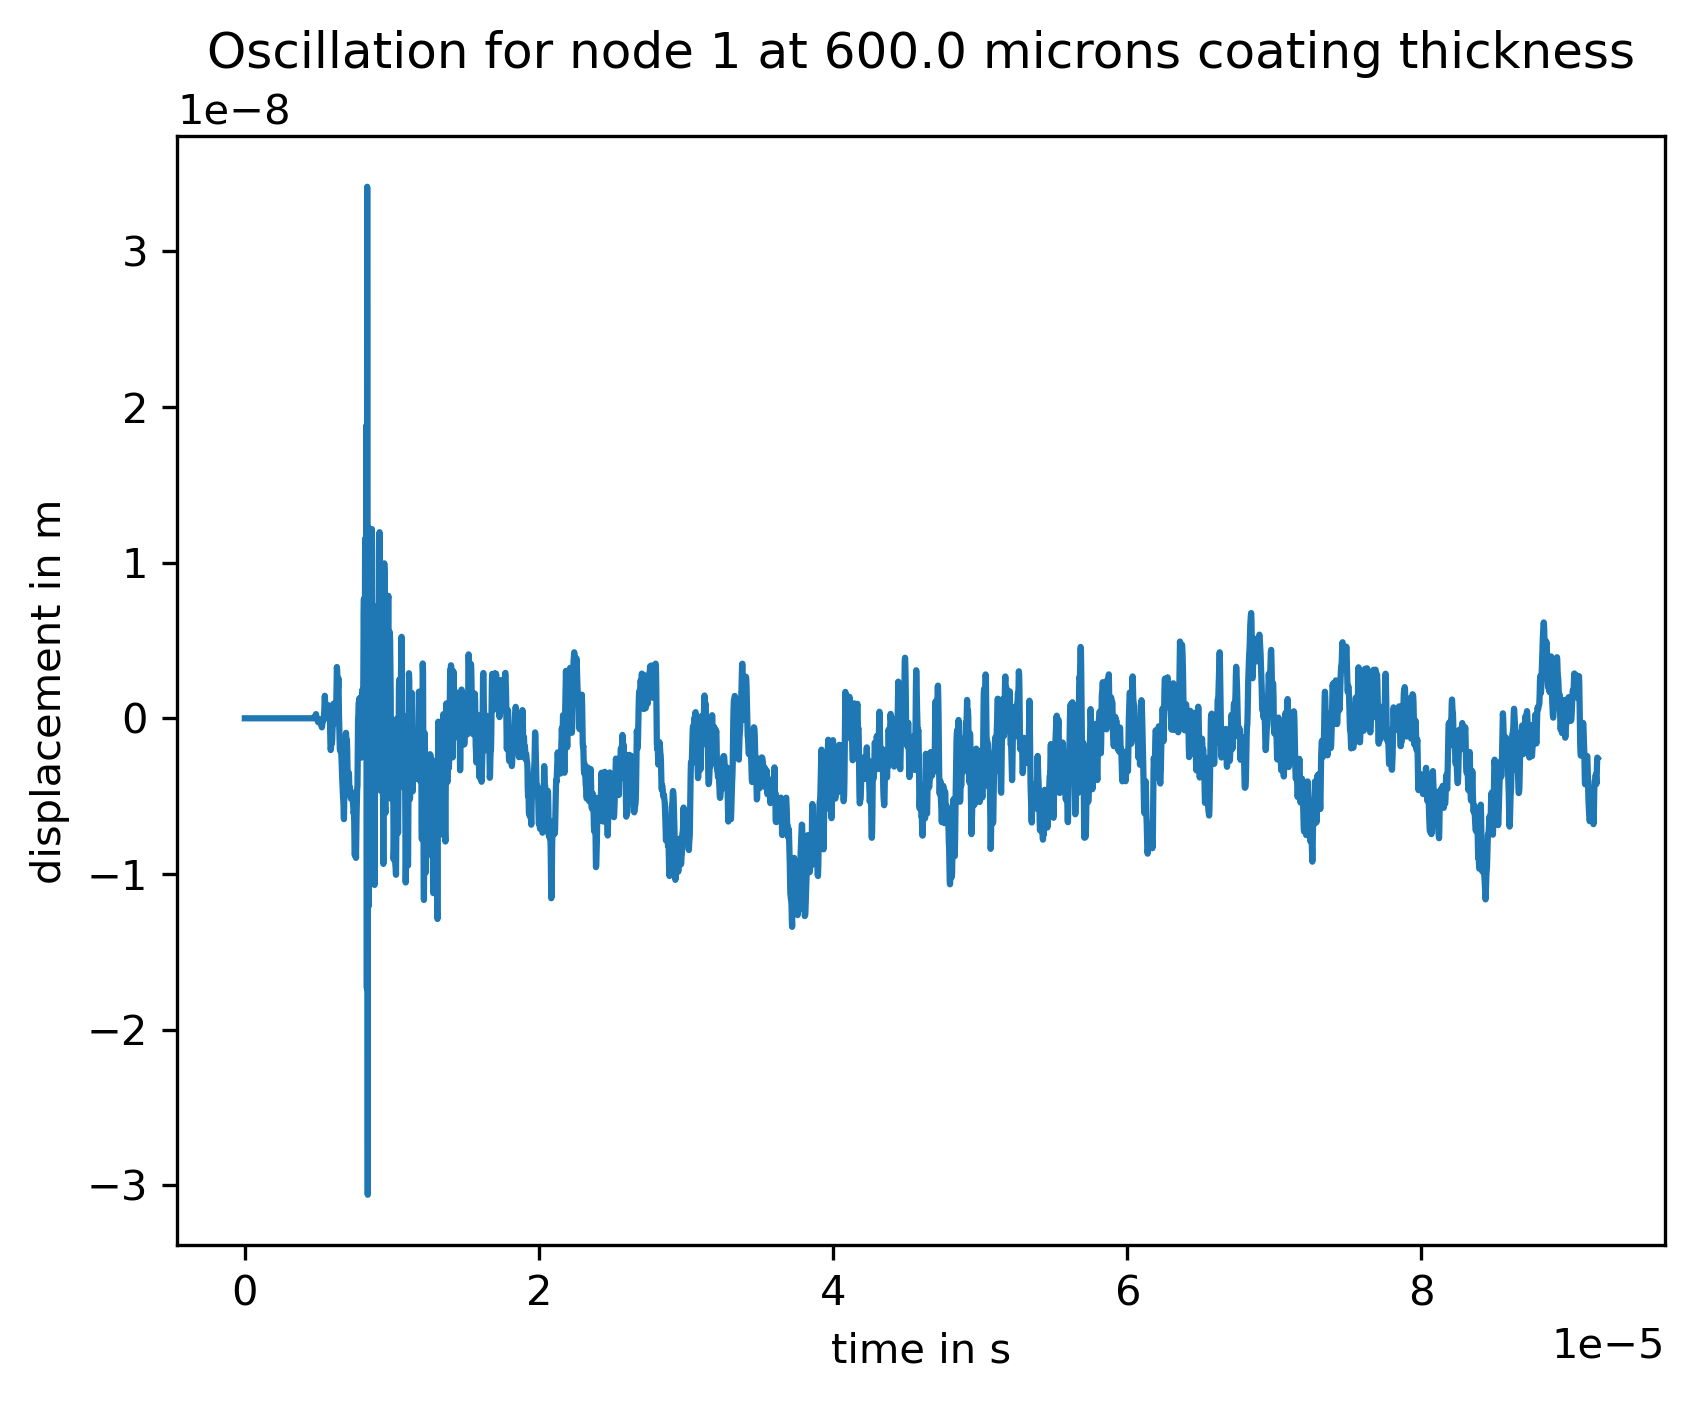

In [51]:
sampling_times = np.arange(0, displacement_timeseries.shape[0]*sim_info['t_sampling'], sim_info['t_sampling'])
fig = plt.figure(1, dpi=300)
ax = fig.gca()
ax.plot(sampling_times, displacement_timeseries)
plt.xlabel('time in s')
plt.ylabel('displacement in m')
plt.title(f'Oscillation for node {node_number} at {coating_height} microns coating thickness')

if save_figures:
    output_file = f'displacement_timeseries_coating_height_{coating_height}_microns.png'
    plt.savefig(figure_path / output_file, bbox_inches='tight', pad_inches=0.1, dpi=300)

## 3. transform the data from the time-displacement domain

### 3.1 Short-Time Fourier Transform (STFT)
For this one, select a specific sampling location and apply the STFT just to that one point with a displacement time series

In [30]:
from scipy import signal
rng = np.random.default_rng()

In [52]:
fs = 1/sim_info['t_sampling']       # get sampling frequency
print(f"The sampling frequency was {fs} Hz")

The sampling frequency was 50000000.0 Hz


In [121]:
def clip_data(input_data: np.ndarray, clip_tr: float = 1E-4):
    """

    :param input_data: numpy input data, can be of arbitrary dimension
    :param clip_tr: threshold for values that are clipped
    :return:
    """
    clipped_data = np.clip(input_data, -clip_tr, clip_tr)
    output_data = np.multiply(clipped_data.copy(), clipped_data > np.median(clipped_data))
    return output_data.copy()

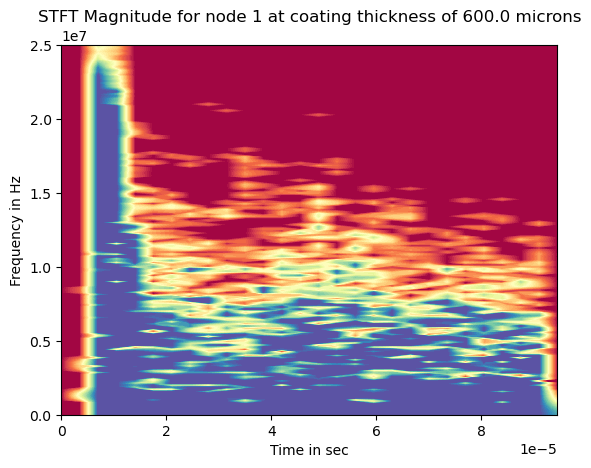

In [196]:
segments = 350     # 80, 128 work fine too
f, t, Zxx = signal.stft(displacement_timeseries, fs, window=signal.get_window('hann', segments, fftbins=True), nperseg=segments, padded=True)

# stft_data_1= np.abs(Zxx)
clip_treshold = 1E-10
stft_data = np.abs(Zxx)
stft_data = clip_data(stft_data, clip_treshold)

plt.contourf(t, f, stft_data, 64, cmap='Spectral')
plt.title(f'STFT Magnitude for node {node_number} at coating thickness of {coating_height} microns')
plt.ylabel('Frequency in Hz')
plt.xlabel('Time in sec')

# if save_figures:
if False:
    output_file = f'stft-{segments}_cltr_{clip_treshold}_coating_height_{coating_height}_microns.png'
    plt.savefig(figure_path / output_file, bbox_inches='tight', pad_inches=0.1, dpi=300)

# look at this one for the reassigned spectrum https://timsainburg.com/time-frequency-reassigned-spectrogram-python.html

### 3.2 Wavelet transform

Use the [PyWavelet](https://pywavelets.readthedocs.io/en/latest/) package to use the wavelet transform.

TODO:
- 1D Wavelet transform
- 2D Wavelet transform
- try different filters

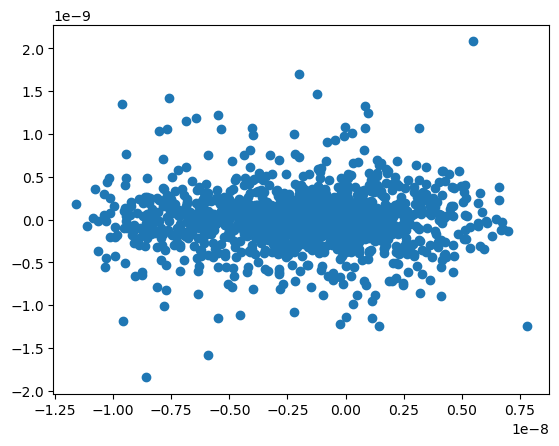

In [51]:
import pywt

cA, cD = pywt.dwt(displacement_timeseries, 'db1')
plt.scatter(cA, cD)

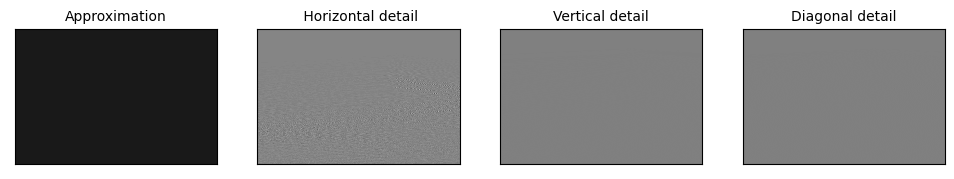

In [46]:
import pywt.data

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

coeffs2 = pywt.dwt2(displacement_x_time, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

### 3.3 2D-FFT transform

Try this to make sure simulated data is consistent with what we have until now

In [59]:
from postprocess_2dfft_max_v15 import apply_2dfft
from utils import cut_quadrants, non_maximum_suppression

In [87]:
fg, kg, abs_fft_data = apply_2dfft(displacement_x_time, sim_info)
fg, kg, abs_fft_data = cut_quadrants(fg, kg, abs_fft_data)

--- np 2dfft time: 4.9787609577178955 seconds ---


In [88]:
# -- clip values of 2dfft
clip_tr = 0.0001
abs_fft_data = np.clip(abs_fft_data, 0, clip_tr)
abs_fft_data = np.multiply(abs_fft_data.copy(), abs_fft_data > np.median(abs_fft_data))

Text(0.5, 1.0, '2D-FFT for coating_thickness = 600.0')

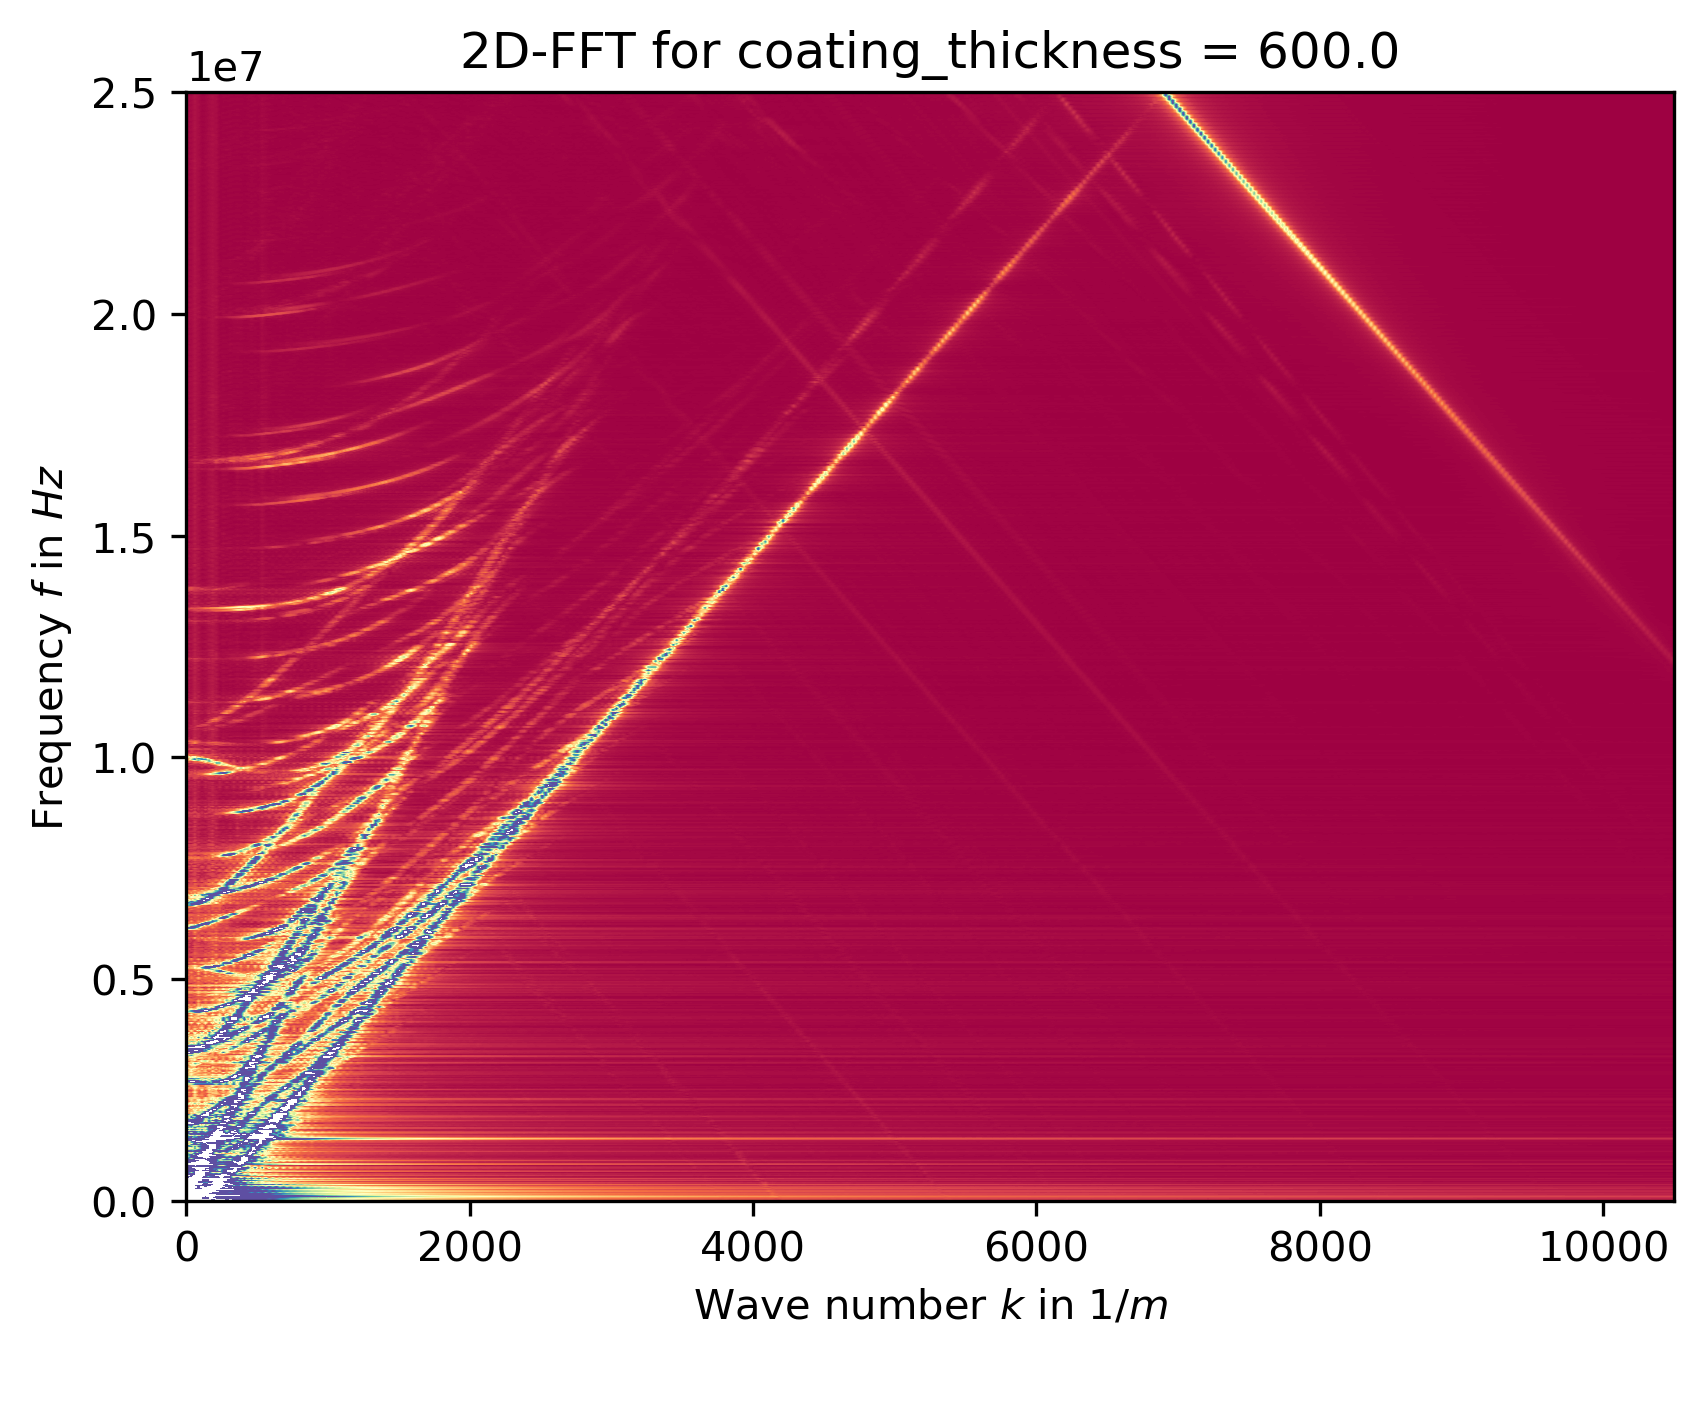

In [89]:
fig = plt.figure(1, dpi=300)
ax = plt.gca()
ax.contourf(fg, kg, abs_fft_data, 300, cmap='Spectral')
plt.axis([0, 10500, 0, 2.5E7])
plt.xlabel(r'Wave number $k$ in $1/m$' + '\n')
plt.ylabel(r'Frequency $f$ in $Hz$')
plt.title(f'2D-FFT for coating_thickness = {coating_height}')

### 3.4 Wigner-Ville Transform

### 3.5 Hilbert Transform

## 4. apply non-maximum suppression

tbd

## 5. use extracte features in machine learning classifiers for classification or even regression

tbd